In [31]:
import time, itertools
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline

#from custom_funcs import *

from ema_workbench import (Model, IntegerParameter, RealParameter, CategoricalParameter, Constant,
                           ScalarOutcome, MultiprocessingEvaluator, Policy, Scenario)

from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.util import ema_logging, save_results, load_results
from ema_workbench.analysis import prim, feature_scoring

from problem_formulation import get_model_for_problem_formulation
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [7]:
dike_model,planning_steps = get_model_for_problem_formulation(2)

In [8]:
policy_dikeheighten = {}
for key in dike_model.levers:
    _,s = key.name.split('_')
    if 'DikeIncrease' in s:
        policy_dikeheighten.update({key.name:np.random.randint(low=0,high=10,size=1)})
    else:
        policy_dikeheighten.update({key.name:np.zeros(1)})
policies_to_evaluate = [Policy('policy_dikeheighten'+str(i),**policy.to_dict())
                        for i,policy in pd.DataFrame.from_dict(policy_dikeheighten).iterrows()]

In [9]:
n_scenarios = 3000

start = time.time()
with MultiprocessingEvaluator(dike_model) as evaluator:
#    results,experiments = evaluator.perform_experiments(scenarios=n_scenarios, policies = policy0)
    experiments,results = evaluator.perform_experiments(scenarios=n_scenarios, policies = policies_to_evaluate)
    end = time.time()
print(end - start, "secs")

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 3000 scenarios * 1 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


3572.4863345623016 secs


In [10]:
results_df = pd.DataFrame.from_dict(results) 
final_df = pd.concat([experiments,results_df],axis=1,sort=False)
final_df.to_csv('results_dikeheightening.csv',index=False)

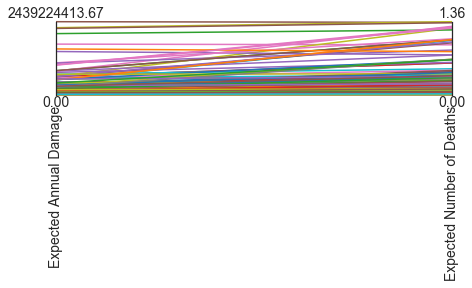

In [32]:
dike_inc = pd.read_csv('results_dikeheightening.csv')
dike_inc.head()
dike_inc['total investment'] =  dike_inc['Dike Investment Costs']
outcomes = dike_inc.loc[:, ['Expected Annual Damage','Expected Number of Deaths']]
from ema_workbench.analysis import parcoords

limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)

# we invert this axis so direction of desirability is the same 
#axes.invert_axis('max_P') 
plt.show()


In [34]:
#outcomes['failure'] = outcomes[outcomes['Expected Number of Deaths']>=0.1]
outcomes['failure'] = np.where(outcomes['Expected Annual Damage']<=100000,1,0)
#outcomes['failure'] = np.where(outcomes['Expected Number of Deaths']>=0.1,1,0)
df_new = outcomes[outcomes['failure']==1]
len(df_new)

283

In [12]:
dike_inc.columns

Index(['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail',
       'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate',
       'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax',
       'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1',
       'discount rate 2', '0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0',
       '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0',
       '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2',
       'EWS_DaysToThreat', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1',
       'A.1_DikeIncrease 2', 'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1',
       'A.2_DikeIncrease 2', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1',
       'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1',
       'A.4_DikeIncrease 2', 'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1',
       'A.5_DikeIncrease 2', 'scenario', 'policy', 'model',
       'Expected Annual Damage', 'Dike Investment Costs',
       'RfR Investment Costs', 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
[MainProcess/INFO] 3000 points remaining, containing 268 cases of interest
[MainProcess/INFO] mean: 0.9411764705882353, mass: 0.051, coverage: 0.5373134328358209, density: 0.9411764705882353 restricted_dimensions: 1


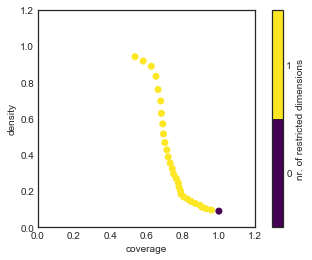

In [33]:
from ema_workbench.analysis import (prim,cart)
y = outcomes['failure'].values
x = dike_inc.ix[:,1:16]
ema_logging.log_to_stderr(ema_logging.INFO);
prim_alg = prim.Prim(x, y, threshold=0.8, peel_alpha=0.1)
box1 = prim_alg.find_box()
import matplotlib.pyplot as plt
 
box1.show_tradeoff()
plt.show()

coverage    0.537313
density     0.941176
id                28
mass           0.051
mean        0.941176
res_dim            1
Name: 28, dtype: object

             box 28                                           
                min       max                        qp values
A.5_pfail  0.000013  0.050952  [-1.0, 3.8120753917223234e-138]



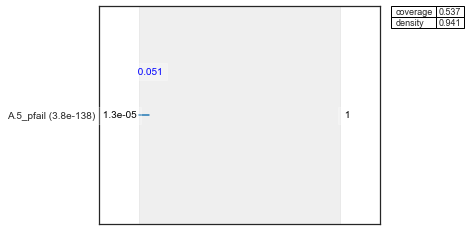

In [34]:
box1.inspect()
box1.inspect(style='graph')
plt.show()

In [9]:
totalcosts_dike_increase = (outcomes['Expected Annual Damage'] + dike_inc['total investment']).values
deaths_dike_increase = outcomes['Expected Number of Deaths'].values


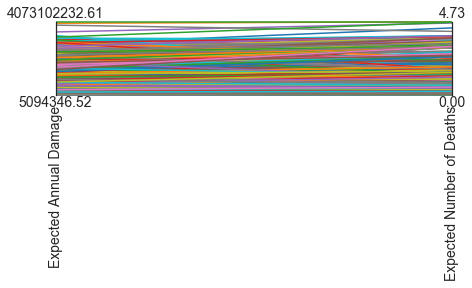

In [30]:
rfr = pd.read_csv('results_rfr.csv')
rfr.head()
rfr['total investment'] =  dike_inc['Dike Investment Costs']
outcomes = rfr.loc[:, ['Expected Annual Damage','Expected Number of Deaths']]
from ema_workbench.analysis import parcoords

limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)

# we invert this axis so direction of desirability is the same 
#axes.invert_axis('max_P') 
plt.show()

In [11]:
totalcosts_rfr = (outcomes['Expected Annual Damage'] + rfr['total investment']).values
deaths_dike_rfr = outcomes['Expected Number of Deaths'].values


Text(0.5,0,'Number of deaths')

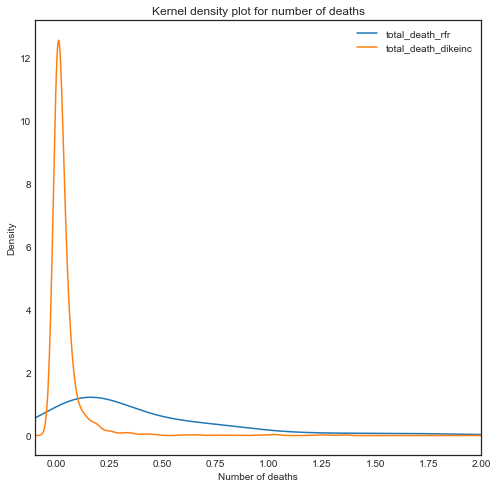

In [26]:
tot_deaths = pd.DataFrame({'total_death_rfr':deaths_dike_rfr,'total_death_dikeinc':deaths_dike_increase})
ax = tot_deaths.plot.kde(figsize=(8,8))
ax.set_xlim(-0.1,2)
plt.title('Kernel density plot for number of deaths')
ax.set_xlabel('Number of deaths')

Text(0.5,0,'Total costs(investment+damage)')

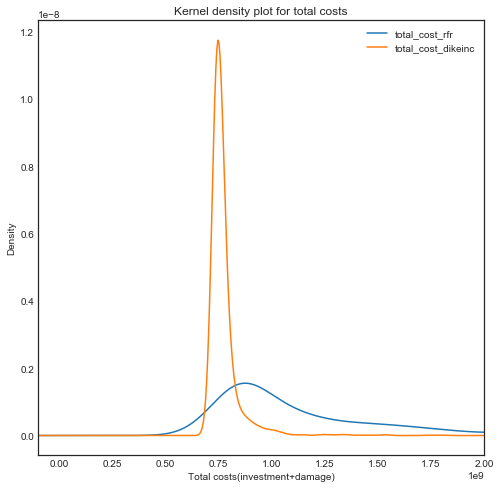

In [28]:
tot_cost = pd.DataFrame({'total_cost_rfr':totalcosts_rfr,'total_cost_dikeinc':totalcosts_dike_increase})
ax = tot_cost.plot.kde(figsize=(8,8))
plt.title('Kernel density plot for total costs')
ax.set_xlim(-0.1e9,2e9)
ax.set_xlabel('Total costs(investment+damage)')